In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
rextract = 0
# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
 
    seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
                
    voxel_size = seg.header['pixdim'][0:3]
    voxel_sizes.append(voxel_size)
    segs.append(seg.get_fdata())

    qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
    qsms.append(qsm.get_fdata())
        
    case_list.append(filename)
    n_cases = len(segs)

    label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
    label_max = np.amax(seg.get_fdata())

F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 01
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 02
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 03
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 04
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 05
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 06
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 07
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 08
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 09
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 10
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 11
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 12
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 13
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 14
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 15
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 16
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 17
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 18
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 19
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 20


In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('Phi_57', 'wb') as fp:  
        pickle.dump(Phi, fp)


In [5]:
with open('Phi_57', "rb") as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [17]:
# UPDRS features
subject_id = np.array((1,2,3,6,9,10,11,12,13,15,16,20,25,26,27,28,29,34,35,41,43,44,45,46,52,54))
pre_updrs_iii_off = np.array((65,22,45,63,63,27,57,42,54,67,33,27,50,77,43,31,56,81,40,28,52,32,33,18,58,63))
pre_updrs_iii_on = np.array((54,7,13,32,21,14,11,14,28,65,9,4,26,55,14,8,24,20,17,0,29,13,26,0,27,36))
post_updrs_iii_off = np.array((11,2,20,3,7,11,15,21,16,21,4,9,15,9,11,4,8,25,13,16,7,26,2,8,19,8))
per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/(pre_updrs_iii_off)

In [18]:
case_id = np.repeat(subject_id,2)

In [19]:
n_cases = subject_id.__len__()

In [98]:
ut = np.zeros((subject_id.__len__()))
for j in np.arange(1,np.max(subject_id)):
    if j in subject_id:
        # Extract numeric feature values
        n_ROIs = 2
        x_row = []
        x_row_t = []
        keys = []
        per_change_train = []
        for i in range(Phi.__len__()//2+1):
            if i in subject_id:
                for ii in range(0,n_ROIs-1):
                    featureVector = Phi[i+ii]
                    for key, value in six.iteritems(featureVector):
                        if 'diagnostic' in key:
                            next
                        else:
                            try:
                                x_row.append(value.ravel())
                            except:
                                x_row.append(value)
                            keys.append(key)
                    if ii == 0 and pre_updrs_iii_off[subject_id == i].__len__()>0:
                        x_row.append((pre_updrs_iii_off[subject_id == i]))
                        x_row.append(post_updrs_iii_off[subject_id == i])
                        x_row.append(pre_updrs_iii_on[subject_id == i])
                        keys.append('pre_updrs_iii_off')
                        keys.append('post_updrs_iii_off')
                        keys.append('pre_updrs_iii_on')
                        per_change_train.append(per_change[subject_id == i])
        jj = int(np.where(subject_id==j)[0])
        X0 = np.array(x_row)
        X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
        X0_t = X[jj,:]
        np.delete(X,jj,0)
        # Normalize testing and training cases together
        #   Set with_mean=False to preserve data sparsity
        #   And with_std=False 
        #   However, need a significant number of samples to do this
        scaler = StandardScaler()
        X_all = np.vstack((X,X0_t))
        X_all_t = scaler.fit_transform(X_all)
        X_t = X_all_t[X.shape[0]:,:]
        X = X_all_t[:X.shape[0]]
        # Cross-validation for model selection
        cv = KFold(n_cases//2)
        # Identify most important features
        clf_in = ElasticNetCV(fit_intercept=True,cv=cv,max_iter=10000).fit(X,np.ravel(per_change_train))
        sfm = SelectFromModel(clf_in,max_features=10,threshold=min(abs(clf_in.coef_[abs(clf_in.coef_)>0])))
        # Initialize pipeline
        clf = Pipeline([('ElasticSelect',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))])
        # Select the optimal number of clusters with grid search
        Cs = ((1e-1,1,10))
        epsilons = ((0.01,0.1))
        clf_nsvr = GridSearchCV(clf,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error')
        clf_nsvr.fit(X,np.ravel(per_change_train))
        ut[jj] = clf_nsvr.best_estimator_.predict(X_t)
        print('Predicted percentage change of',ut[jj],'for case',j)
        print('True percentage change',per_change_train[jj])
        #print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))
        #print(clf_nsvr.best_estimator_.get_params('SVR__C'))




Predicted percentage change of 0.8406959570342767 for case 1
True percentage change [0.83076923]
Predicted percentage change of 0.8987272679207667 for case 2
True percentage change [0.90909091]
Predicted percentage change of 0.5656498488085867 for case 3
True percentage change [0.55555556]
Predicted percentage change of 0.9425525000644799 for case 6
True percentage change [0.95238095]
Predicted percentage change of 0.8932522836509847 for case 9
True percentage change [0.88888889]
Predicted percentage change of 0.6027605365463219 for case 10
True percentage change [0.59259259]
Predicted percentage change of 0.7460957339532089 for case 11
True percentage change [0.73684211]
Predicted percentage change of 0.5100540801019127 for case 12
True percentage change [0.5]
Predicted percentage change of 0.6935938755794581 for case 13
True percentage change [0.7037037]
Predicted percentage change of 0.68420186304968 for case 15
True percentage change [0.68656716]
Predicted percentage change of 0.86

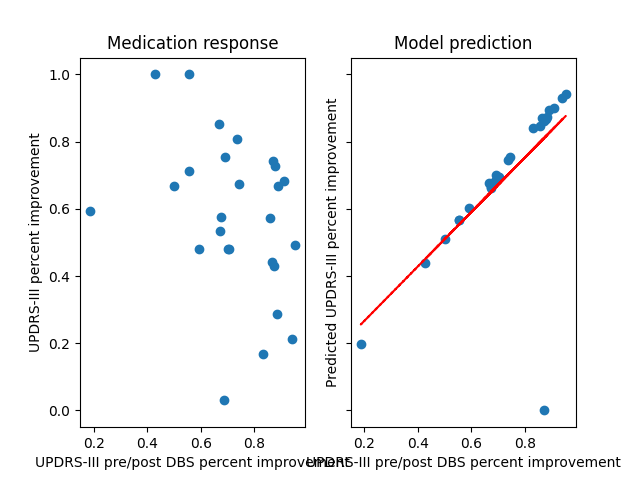

In [99]:
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
ax[0].scatter(per_change,lct_change)
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
r2_score(per_change,p(per_change))
ax[0].set_title('Medication response')
ax[0].set_xlabel("UPDRS-III pre/post DBS percent improvement")
ax[0].set_ylabel("UPDRS-III percent improvement")
ax[1].scatter(per_change,ut)
z = np.polyfit(per_change,ut,1)
p = np.poly1d(z)
ax[1].plot(per_change,p(per_change),"r--")
ax[1].set_title('Model prediction')
ax[1].set_xlabel("UPDRS-III pre/post DBS percent improvement")
ax[1].set_ylabel("Predicted UPDRS-III percent improvement")
plt.show()

In [100]:
r2_score(per_change,p(per_change))

0.9291985499946199

In [101]:
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
r2_score(per_change,p(per_change))

-1.8041590503366502

In [102]:
feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
for k in range(feats.__len__()-1):
    if feats[k] == True:
        print(keys[k])



original_glszm_SizeZoneNonUniformityNormalized
gradient_glcm_InverseVariance
lbp-3D-k_gldm_LargeDependenceHighGrayLevelEmphasis
logarithm_glszm_LargeAreaLowGrayLevelEmphasis
wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis
wavelet-HLH_firstorder_Skewness
wavelet-HHH_glszm_SmallAreaHighGrayLevelEmphasis
wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis
pre_updrs_iii_off
post_updrs_iii_off


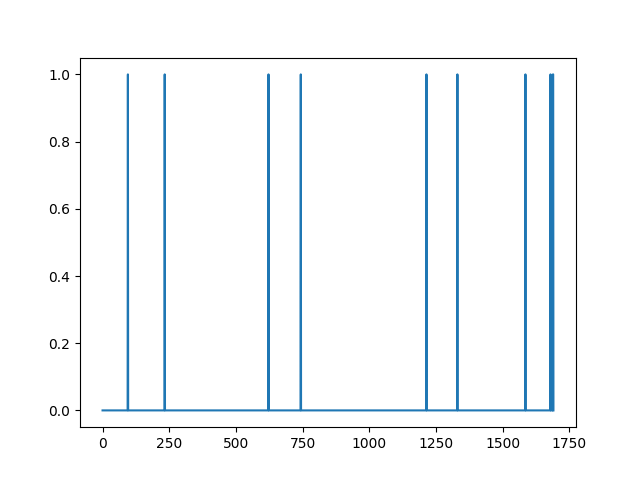

In [103]:
fig,ax = plt.subplots(1,1)
plt.plot(feats)
plt.show()

In [104]:
clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape

(26, 10)

In [105]:
np.array(clf_nsvr.best_estimator_.predict(X))

array([0.82110074, 0.89871018, 0.56587595, 0.94277072, 0.87874032,
       0.60240662, 0.72674388, 0.51037795, 0.69370795, 0.67658023,
       0.86838089, 0.67690973, 0.68998372, 0.87289257, 0.73416261,
       0.860938  , 0.84709053, 0.70133459, 0.6851376 , 0.43848142,
       0.87544587, 0.19778976, 0.92936266, 0.56547164, 0.66208512,
       0.86297115])

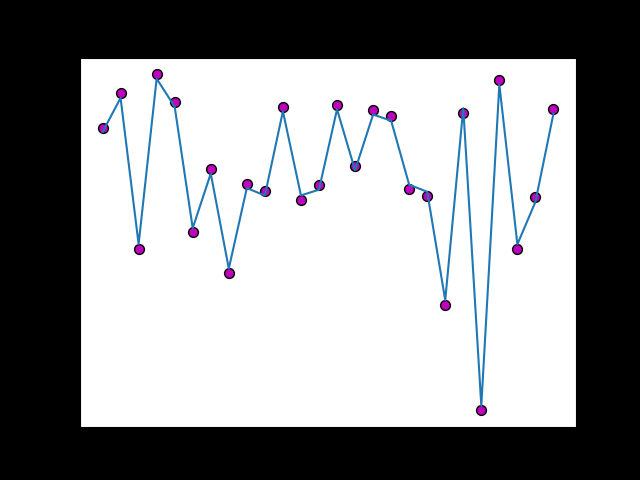

In [106]:
cases = np.linspace(1,n_cases,n_cases)
fig,ax = plt.subplots(1,1)
sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
# Plot remaining data
plt.scatter(cases, per_change, label="data", zorder=2, c="c", edgecolors=(0, 0, 0))
# Plot support vectors
plt.scatter(
    cases[sv_ind],
    per_change[sv_ind],
    s=50,
    c="m",
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0))


plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X))),
plt.style.use('dark_background')
plt.show()

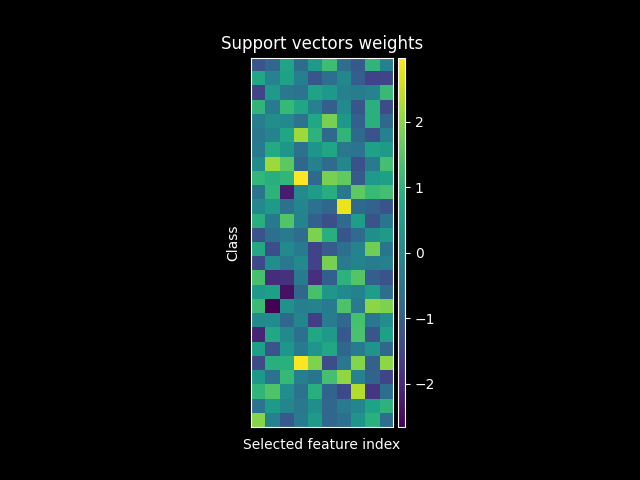

In [107]:
X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
fig,ax = plt.subplots(1,1)
im_svr = plt.imshow(X_SVR)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vectors weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svr,cax=cax,orientation='vertical')


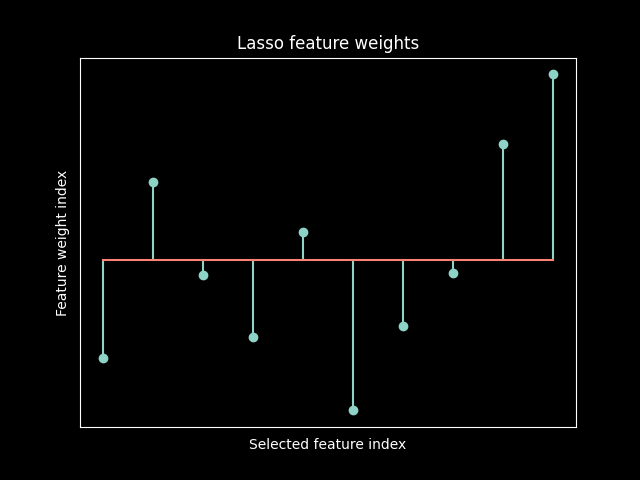

In [108]:
X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso.ravel())
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');